# Embeddings con OpenAI
Embeddings es un proceso mediante el cual se utiliza alguna tecnica/algoritmo que sea capaz de convertir palabras o texto a vectores de N dimensiones. Estos vectores contienen cierto nivel de información semantica sobre el texto o palabra. Por ejemplo, palabras que son muy similares van a tener valores cercanos en sus representaciones en vectores.

Hay varios modelos que son capaces de hacer un embedding de nuestro texto, en este cuaderno estaremos utilizando el embedding de OpenAI, el cual tiene la capacidad de posicionas muy bien palabras o textos segun su semantica. Este es el mismo embedding que utiliza GPT3. En este cuaderno estarás haciendo embedding de un texto para despues poder buscar cosas dentro de este texto por medio de preguntas en lenguaje natural.

In [ ]:
# Importamos todas las dependencias requeridas, en este caso será Gradio para desarrollar la interfaz grafica y openai para realizar los llamados a su API 
import gradio as gr
import openai
import pandas as pd

from openai.embeddings_utils import get_embedding
from openai.embeddings_utils import cosine_similarity

In [ ]:
# Definimos la API Key para vincular el cuaderno con nuestra cuenta de OpenAI
openai.api_key = ""

# Que es y cómo usar embeddings
Al hacer embedding de un dato, lo estamos convirtiendo a un vector numérico, datos similares estarán más cercanos entre si cuando semanticamente son similares

In [ ]:
# Se puede hacer embeeding de palabras o cadenas de texto
palabras = ["casa", "perro", "gato", "lobo", "leon", "zebra", "tigre"]

In [ ]:
diccionario = {}
for i in palabras:
    diccionario[i] = get_embedding(i, engine="text-embedding-ada-002")
    

In [ ]:
diccionario.keys()


In [ ]:
palabra = "gato"
print("Primeros 10 valores de {}:\n".format(palabra), diccionario[palabra][:10])
print("\n")
print("Número de dimensiones del dato embebido\n", len(diccionario[palabra]))


## Comparar dos embeddings
Debido a que los embeddings son una representacion vectorial de los datos en un espacio latente, podemos medir la distancia entre dos vectores y asi obtener que tan similares son. Podemos comparar una palabra nueva o alguna de las que ya fueron embebidas 
OJO: No necesariamente es similitud al objeto. Ej. perro y gato aun siendo "opuestos" semanticamente estan cerca pues tienen una relación.

In [ ]:
n_palabra = "gato" # Palabra nueva a comparar
palabra_comparar = "perro" # Palabra del diccionario con la que compararemos la nueva palabra
n_palabra_embed = get_embedding(n_palabra, engine="text-embedding-ada-002")
similitud = cosine_similarity(diccionario[palabra_comparar], n_palabra_embed)
print(similitud)

# Sumar embeddings
Como los vectores contienen valores numericos, podemos sumarlos y el resultado será un nuevo vector de un concepto que una los elementos sumados

In [ ]:
# Suma dos listas usando pandas
sumados = (pd.DataFrame(diccionario["leon"])) + (pd.DataFrame(diccionario["zebra"]))
len(sumados)

for key, value in diccionario.items():
    print(key, ":", cosine_similarity(diccionario[key], sumados))


# Aplicacion de un Chatbot

Usaremos Gradio para hacer una interfaz básica donde podremos hacer preguntas y obtendremos una respuesta. 
Para esto reutilizaremos lo que hemos visto hasta el momento pero usaremos el archivo de **chatbot_qa.csv**

In [ ]:
#para evitar alucinaciones se le da las posibles respues 
def embed_text(path="texto.csv"):
    conocimiento_df = pd.read_csv(path)
    conocimiento_df['Embedding'] = conocimiento_df['texto'].apply(lambda x: get_embedding(x, engine='text-embedding-ada-002'))
    conocimiento_df.to_csv('embeddings.csv')
    return conocimiento_df

def buscar(busqueda, datos, n_resultados=5):
    busqueda_embed = get_embedding(busqueda, engine="text-embedding-ada-002")
    datos["Similitud"] = datos['Embedding'].apply(lambda x: cosine_similarity(x, busqueda_embed))
    datos = datos.sort_values("Similitud", ascending=False)
    return datos.iloc[:n_resultados][["texto", "Similitud", "Embedding"]]

texto_emb = embed_text("./chatbot_qa.csv")

with gr.Blocks() as demo:
    busqueda = gr.Textbox(label="Buscar")
    output = gr.DataFrame(headers=['texto'])
    greet_btn = gr.Button("Preguntar")
    greet_btn.click(fn=buscar, inputs=[busqueda, gr.DataFrame(texto_emb)], outputs=output)

demo.launch()

# Procesar datos de un PDF
Haremos ahora un ejemplo donde leemos un PDF para poder hacer preguntas y traer un exctracto del PDF

In [ ]:
# pip install langchain pypdf
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter

loader = PyPDFLoader("./mtg.pdf")
pages = loader.load_and_split()

In [ ]:
# Un elemento por cada página

pages[3].page_content

In [ ]:
# Objeto que va a hacer los cortes en el texto
split = CharacterTextSplitter(chunk_size=300, separator = '.\n')

In [ ]:
textos = split.split_documents(pages) # Lista de textos

In [ ]:
print(textos[2].page_content)
#print(textos[0])

In [ ]:
# Extraemos la parte de page_content de cada texto y lo pasamos a un dataframe
textos = [str(i.page_content) for i in textos] #Lista de parrafos
parrafos = pd.DataFrame(textos, columns=["texto"])
print(parrafos)

In [ ]:
parrafos['Embedding'] = parrafos["texto"].apply(lambda x: get_embedding(x, engine='text-embedding-ada-002')) # Nueva columna con los embeddings de los parrafos
parrafos.to_csv('MTG.csv')

In [ ]:
# La misma funcion del chatbot de pregunts y respuestas
def embed_text(path="texto.csv"):
    conocimiento_df = pd.read_csv(path)
    conocimiento_df['Embedding'] = conocimiento_df['texto'].apply(lambda x: get_embedding(x, engine='text-embedding-ada-002'))
    conocimiento_df.to_csv('mtg-embeddings.csv')
    return conocimiento_df

def buscar(busqueda, datos, n_resultados=5):
    busqueda_embed = get_embedding(busqueda, engine="text-embedding-ada-002")
    datos["Similitud"] = datos['Embedding'].apply(lambda x: cosine_similarity(x, busqueda_embed))
    datos = datos.sort_values("Similitud", ascending=False)
    return datos.iloc[:n_resultados][["texto", "Similitud", "Embedding"]]

texto_emb = parrafos
with gr.Blocks() as demo:
    busqueda = gr.Textbox(label="Buscar")
    output = gr.DataFrame(headers=['texto'])
    greet_btn = gr.Button("Preguntar")
    greet_btn.click(fn=buscar, inputs=[busqueda, gr.DataFrame(texto_emb)], outputs=output)

demo.launch()


# resp = buscar("Con cuanta vida empiezo?", parrafos, 5) # Reutilizamos la funcion de "buscar" del app de gradio

Number of samples: 6


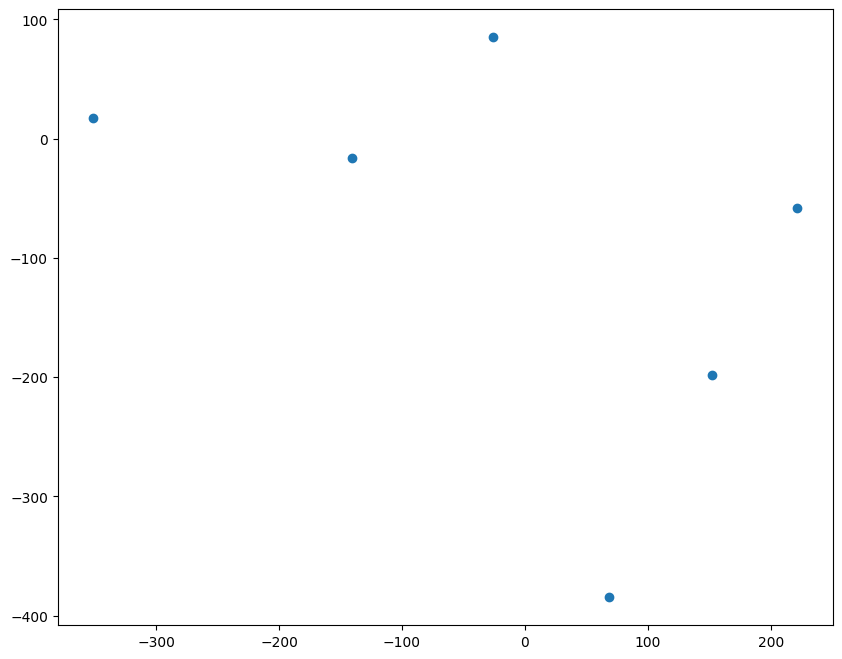

In [2]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('embeddings.csv')

# Convert the list of embeddings into a NumPy array
matrix = np.array(df.Embedding.apply(eval).tolist())

# Determine the number of samples
num_samples = matrix.shape[0]
print(f"Number of samples: {num_samples}")

# Set a lower perplexity value
tsne = TSNE(n_components=2, perplexity=3, random_state=42, init='random', learning_rate=200)
tsne_results = tsne.fit_transform(matrix)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.show()


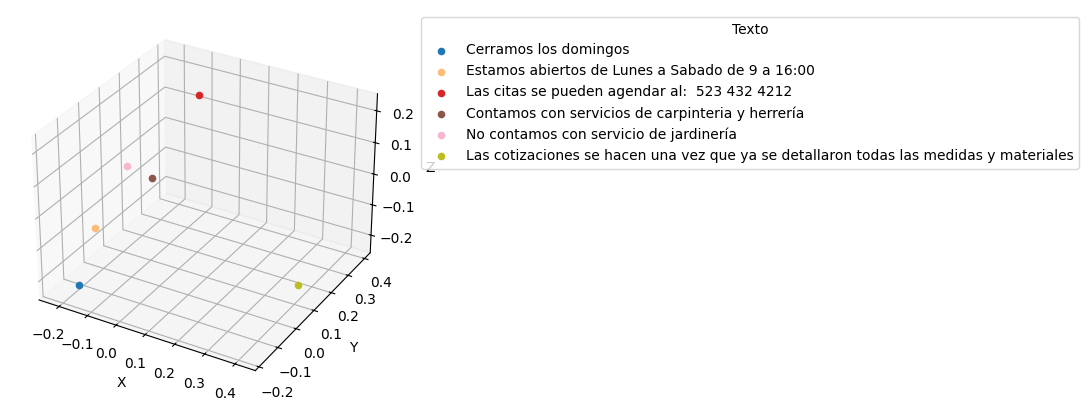

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Cargar los embeddings desde el archivo CSV
embeddings_df = pd.read_csv('embeddings.csv')

# Convertir la columna 'Embedding' a una matriz numpy
matrix = np.array(embeddings_df['Embedding'].apply(eval).tolist())

# Reducir a 3 dimensiones
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(matrix)

# Agregar las dimensiones reducidas al DataFrame
embeddings_df['embed_vis'] = vis_dims.tolist()

# Crear un mapa de colores para cada texto único
unique_texts = embeddings_df['texto'].unique()
cmap = plt.get_cmap('tab20')
color_map = {text: cmap(i / len(unique_texts)) for i, text in enumerate(unique_texts)}

# Configurar la visualización en 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

# Asignar colores a los puntos y graficarlos
for text in unique_texts:
    sub_matrix = np.array(embeddings_df[embeddings_df['texto'] == text]['embed_vis'].tolist())
    x = sub_matrix[:, 0]
    y = sub_matrix[:, 1]
    z = sub_matrix[:, 2]
    ax.scatter(x, y, z, color=color_map[text], label=text)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Mostrar la leyenda
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Texto")
plt.show()


In [ ]:
# la primera parte del codigo se saco del repositorio https://github.com/puigalex autor: Alejandro Puig
# la parte final del codigo se saca y se modifica de https://cookbook.openai.com/examples/visualizing_embeddings_in_3d